# E-media decodowanie formatu PNG

In [1]:
import zlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

In [2]:
path = "sample_with_PLTE.png"
file = open(path, "rb")

## Weryfikacja sygnatury

#### Pierwsze 8 byte'ow pliku PNG zawiera sygnature fromatu Sygnatura PNG `137 80 78 71 13 10 26 10`

In [3]:
def verifySignature(file):
    signature = file.read(8)
    if signature != bytes([137, 80, 78, 71, 13, 10, 26, 10]):
        print("Invalid PNG file")
        return False
    return True
verifySignature(file)

True

## Chunki

##### Długość

- 4-bajtowa liczba całkowita bez znaku podająca liczbę bajtów w polu danych fragmentu. Długość obejmuje tylko pole danych, a nie samo pole.

##### Typ Chunku

- Kod typu fragmentu 4-bajtowego. Dla wygody opisu i badania plików PNG, kody typu są ograniczone do wielkich i małych liter ASCII (A-Z i a-z lub 65-90 i 97-122 w systemie dziesiętnym).

##### Zawartość chunku

- Bajty danych odpowiednie dla typu fragmentu, jeśli takie istnieją. To pole może mieć długość zerową.

##### CRC
- 4-bajtowy CRC (Cyclic Redundancy Check). Wykrywa błędy w przesyłanych lub przechowywanych danych. Sprawdza czy dane nie zostały uszkodzone podczas transmisji lub zapisu.

In [4]:
class Chunk:
    def __init__(self, length, type, data, crc):
        self.length = length
        self.type = type
        self.data = data
        self.crc = crc

    def __str__(self):
        return f"Chunk(type={self.type}, length={self.length}, crc={self.crc.hex()})"

### Celem CRC jest wykrywanie błędów w danych. Obliczamy specjalną liczbę na podstawie danych w chunku. Jeśli dane zostaną zmodyfikowane, to obliczona suma kontrolna też się zmieni.

In [5]:
def compute_crc32(data: bytes):
    crc = 0xFFFFFFFF
    for byte in data:
        crc ^= byte # Dla kazdego bajtu XOR z crc
        for _ in range(8):
            if crc & 1: # jesli ostatni bit jest 1
                # przesun crc w prawo o 1 i XOR z polinomem
                crc = (crc >> 1) ^ 0xEDB88320
            else:
                # przesun crc w prawo o 1
                crc >>= 1
    
    return crc ^ 0xFFFFFFFF # na koniec odwracamy crc

def verify_crc(chunk):
    to_check = chunk.type.encode('utf-8') + chunk.data
    computed_crc = compute_crc32(to_check)
    file_crc = int.from_bytes(chunk.crc, 'big')

    if computed_crc != file_crc:
        print(f"[BŁĄD CRC] Chunk: {chunk.type}, CRC z pliku: {file_crc:08X}, Obliczone: {computed_crc:08X}")
        return False
    else:
        print(f"[OK CRC] Chunk: {chunk.type}, CRC: {computed_crc:08X}")
        return True

## Odczyt chunków

In [6]:
def read_chunks(file):
    file.seek(8)
    chunks = [] # pusta lista w której przechowywane są odczytane chunki
    while True:
        length_bytes = file.read(4)

        length = int.from_bytes(length_bytes, 'big') # konwertujemy odczytane bajty na liczbę całkowitą
        type = file.read(4).decode('utf-8') # odczyt typu poprzez zdekodowanie 4 bajtów z formatu UTF-8
        data = file.read(length) # odczyt danych
        crc = file.read(4)

        chunk = Chunk(length, type, data, crc) # obiekt klasy Chunk przechowuje odczytane dane 
        verify_crc(chunk)
        chunks.append(chunk) #obiekt chunk dodajemy do listy chunks
        if type == "IEND":
            break
    return chunks # zwrocenie listy chunkow

chunks = read_chunks(file)
for chunk in chunks:
    print(chunk)

[OK CRC] Chunk: IHDR, CRC: 282D0F53
[OK CRC] Chunk: PLTE, CRC: A6DCC526
[OK CRC] Chunk: IDAT, CRC: 1582273F
[OK CRC] Chunk: IEND, CRC: AE426082
Chunk(type=IHDR, length=13, crc=282d0f53)
Chunk(type=PLTE, length=768, crc=a6dcc526)
Chunk(type=IDAT, length=28, crc=1582273f)
Chunk(type=IEND, length=0, crc=ae426082)


## Chunki krytyczne

#### `IHDR` (Image Header) oraz `IEND`
Fragmenty mogą pojawiać się w dowolnej kolejności, z zastrzeżeniem ograniczeń nałożonych na każdy typ fragmentu. Jednym z ważniejszych ograniczeń jest to, że `IHDR` musi pojawić się jako pierwszy, a `IEND` jako ostatni

In [7]:
def decode_IHDR(chunk):
    if chunk.type != "IHDR":
        raise ValueError("Chunk is not IHDR")
    
    image_info = {
        "width": int.from_bytes(chunk.data[0:4], 'big'), # szerokosc obrazu 
        "height": int.from_bytes(chunk.data[4:8], 'big'), # wysokosc obrazu
        "bit_depth": chunk.data[8], # głębia bitowa 
        "color_type": chunk.data[9], # typ koloru
        "compression_method": chunk.data[10], # metoda kompresji tylko 0 (deflate zlib)
        "filter_method": chunk.data[11], # metoda filtrowania
        "interlace_method": chunk.data[12] # metoda przeplatania
    }
    return image_info

IHDR = decode_IHDR(chunks[0])
print(IHDR)

{'width': 16, 'height': 16, 'bit_depth': 8, 'color_type': 3, 'compression_method': 0, 'filter_method': 0, 'interlace_method': 0}


In [8]:
def decode_IDAT(chunks):
    compressed_data = b'' # pusty najtowy ciąg
    
    for chunk in chunks:
        if chunk.type == "IDAT":
            compressed_data += chunk.data
    try:
        decompressed_data = zlib.decompress(compressed_data) # dekompresja danych 
        return decompressed_data
    except zlib.error as e:
        return None # jezeli dekompresja sie nie powiedzie
print(decode_IDAT(chunks))

b'\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\x0c\r\x0e\x0f'


### PLTE Palette

- Header `PLTE` jest opcjonalny, chyba ze bajt typu coloru jest ustawiony na PLTE (3)
- Header `PLTE` zawiera palete kolorów które sa używane przez obraz PNG
- Każdy piksel w obrazie mapuje sie na jeden z kolorów w palecie zamiast bezpośrednio przechowywać wartosci `RGB` (kompresja)

[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128), (192, 192, 192), (128, 128, 128), (64, 64, 64), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0

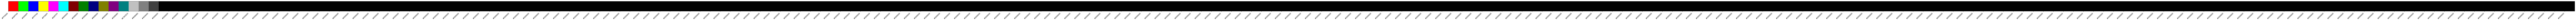

In [9]:
def decode_PLTE(chunk):
    if chunk.type != "PLTE":
        raise ValueError("Not a PLTE chunk")
    
    else:
        palette = []  # lista do której będą dodawane kolory
        for i in range(0, len(chunk.data), 3):
            r = chunk.data[i]     # czerwony 
            g = chunk.data[i+1]   # zielony 
            b = chunk.data[i+2]   # niebieski
            palette.append((r, g, b))
        print(palette)
        return palette  # zwracamy całą listę RGB
    

def show_palette(palette):
    fig, ax = plt.subplots(figsize=(len(palette), 1))
    ax.imshow([palette], extent=[0, len(palette), 0, 1])
    ax.set_xticks(range(len(palette)))
    ax.set_yticks([])
    ax.set_xticklabels([f"#{r:02X}{g:02X}{b:02X}" for (r, g, b) in palette], rotation=45, ha='right')
    plt.show()

plte_chunk = next((chunk for chunk in chunks if chunk.type == "PLTE"), None) # iteruje po chunks, sprawdza, czy chunk.type == "PLTE", jeśli tak, zwraca ten chunk

if plte_chunk:
    palette = decode_PLTE(plte_chunk)
    show_palette(palette)
else:
    print("Nie znaleziono chunku PLTE")


In [10]:
def validate_palette(chunk):
    palette = decode_PLTE(chunk)
    clear_palette = set(palette)
    clear_palette = list(clear_palette)
    clear_palette.sort()
    return b''.join(bytes([r, g, b]) for r, g, b in clear_palette)

### tEXt
- pozwala osadzić prosty tekst `ASCII` w pliku
- brak kompresji

In [11]:
def decode_tEXt(chunk):
    if chunk.type == "tEXt":
        null_index = chunk.data.index(b'\x00')
        keyword = chunk.data[:null_index].decode('utf-8')
        text = chunk.data[null_index + 1:].decode('latin-1')
        print(f"tEXt: {keyword}: {text}")

### zTXt
- pozwala osadzić prosty tekst `ASCII` w pliku
- zkompresowany `zlib'em`

#### Struktura zTXt :
Pole | Typ  | opis
--- | ---  | ---
keyword | ASCII | nagłówek
nullseparator | 1 bajt  |
typ kompresji | 1 bajt | 0/1 zlib/deflate
zkompresowany tekst | reszta bajtów |


In [12]:
def decode_zTXt(chunk):
    if chunk.type == "zTXt":
        null_index = chunk.data.index(b'\x00')
        keyword = chunk.data[:null_index].decode('latin-1')
        compression = chunk.data[null_index + 1] # odczytuje jeden bajt dotyczacy typu kompresji 
        compressed_text = chunk.data[null_index + 2:] # odczytuje skompresowane dane
        if compression == 0:
            decompressed_text = zlib.decompress(compressed_text).decode('latin-1')
            print(f">> {decompressed_text}")

### iTXt
- pozwala zapisać tekst w formacie `UTF-8`
- opcjonalna kompresja

##### Struktura iTXt :
Pole | Typ  | opis
--- | ---  | ---
keyword | ASCII | nagłówek
flaga kompresji | 1 bajt  | 0/1 nie/tak
typ kompresji | 1 bajt | 0 zlib/deflate 1 niedozwolone
jezyk | ASCII | "en" "pl"
keyword w utf-8| UTF-8
zkompresowany tekst | UTF-8 | reszta bajtów 

In [13]:
def decode_iTXt(chunk):
    if chunk.type == "iTXt":
            # Znajdź koniec słowa kluczowego (ASCII)
            keyword_end = chunk.data.index(b'\x00', 1)
            keyword = chunk.data[1:keyword_end].decode('utf-8')
        
            # Flaga kompresji (po słowie kluczowym)
            compression_flag = chunk.data[keyword_end + 1]
            
            # Typ kompresji (1 bajt)
            compression_type = chunk.data[keyword_end + 2]
            
            # Zakończenie tagu języka
            language_tag_end = chunk.data.index(b'\x00', keyword_end + 3)
            language_tag = chunk.data[keyword_end + 3:language_tag_end].decode('utf-8')
            
            # Zakończenie tłumaczonego słowa kluczowego
            translated_keyword_end = chunk.data.index(b'\x00', language_tag_end + 1)
            translated_keyword = chunk.data[language_tag_end + 1:translated_keyword_end].decode('utf-8')
            
            text_start = translated_keyword_end + 1
            text_data = chunk.data[text_start:]
            
            # Obsługuje kompresję
            if compression_flag == 1:
                try:
                    text = zlib.decompress(text_data).decode('utf-8')
                except zlib.error:
                    text = "Błąd dekompresji"
            else:
                text = text_data.decode('utf-8')
            
            print(f"iTXt: {keyword}: {text}")

### tIME

- służy do przechowywania ostatniej edycji pliku

rozmiar (bajty) |  opis
--- | ---  
2 | rok
1 | miesiac
1 | dzien
1 | godzina
1 | minuta
1 | sekunda

In [14]:
def decode_tIME(chunk):
        if chunk.type == "tIME": # ostatnia modyfikacja obrazu
                year = int.from_bytes(chunk.data[0:2], "big")
                month = chunk.data[2]
                day = chunk.data[3]
                hour = chunk.data[4]
                minute = chunk.data[5]
                second = chunk.data[6]
                print(f">> {year}-{month:02}-{day:02} {hour:02}:{minute:02}:{second:02}")

### bKGD

- struktura nagłowka `bKGB` jest zależna od pola bajtów `Color type` z IHDR'a

Color type pliku | opis  | dane w `bKGB`
--- | ---  | ---
0 | Grayscale | 2bajty przedstawiacje wartość odcieni szarości
2 | RGB  | 6 bajtow po 2 na kazdy z kolorow
3 | 1 bajt | index z PLTE
4,6 | Z alpha |

In [15]:
def decode_bKGD(chunk):
    if chunk.type == "bKGD":  # Informuje o tle obrazu
        if len(chunk.data) == 1:
            # Dla trybu z paletą: indeks koloru w palecie PLTE
            print(f">> PLTE index: {chunk.data[0]}")

        elif len(chunk.data) == 2:
            # Dla trybu grayscale: odcień szarości (2 bajty)
            grayscale_value = int.from_bytes(chunk.data, "big")
            print(f">> Grayscale: {grayscale_value}")

        elif len(chunk.data) == 6:
            # Dla trybu RGB: 6 bajtów (2 bajty dla każdego koloru)
            r = int.from_bytes(chunk.data[0:2], "big")
            g = int.from_bytes(chunk.data[2:4], "big")
            b = int.from_bytes(chunk.data[4:6], "big")
            print(f">> R: {r}, G: {g}, B: {b}")
        else:
            print("Unexpected chunk length for bKGD.")

### gAMA

- zawiera informacje o gamm'ie obrazu, które określają, jak jasność (lub intensywność) kolorów w obrazie jest dostosowana
- wartość jest przechowywana jako wartość zmienno przecinkowa przemnożona przez 100 000

In [16]:
def decode_gAMA(chunk):
    if chunk.type == "gAMA": # określa, jak bardzo jasność piksela zmienia się w porównaniu do jego wartości liczbowej
        gamma_val = int.from_bytes(chunk.data, "big") / 100000.0
        print(f">> Gamma: {gamma_val}")

### pHYs 

- zawiera informacje o fizycznych wymiarach obrazu, tj. jak wiele jednostek (pikseli) odpowiada jednej jednostce fizycznej (np. calowi, milimetrowi itp.).

dane w `pHYs`
bajty | opis 
--- | --- 
4 | liczba pikseli X
4 | liczba pikseli Y
1 | Jednostka używana do określenia wartości X i Y (0 – brak jednostki, 1 – piksele na cal (PPI), 2 – piksele na centymetr (PPCM))

In [17]:
def decode_pHYs(chunk):
    if chunk.type == "pHYs": # rozdzielczosc fizyczna 
            x = int.from_bytes(chunk.data[0:4], "big")
            y = int.from_bytes(chunk.data[4:8], "big")
            unit = chunk.data[8]
            print(f">> X: {x}, Y: {y}, Unit: {unit}")

# XMP I EXIF

### XMP
W iTXt można przechowywac np pliki .xmp
XMP to format metadanych opracowany przez firmę Adobe

``````XML
<x:xmpmeta xmlns:x="adobe:ns:meta/"> – Określa, że jest to dokument w przestrzeni XMP (Adobe).

<rdf:RDF xmlns:rdf="..." – Główna struktura RDF, która jest wykorzystywana do opisania metadanych.

<rdf:Description rdf:about=""> – Miejsce na metadane natemat obiektu. rdf:about="" wskazuje, że ten opis odnosi się do bieżącego pliku.

<x:xmpmeta xmlns:x="adobe:ns:meta/" xmlns:custom="http://example.com/custom">
  <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22/rdf-syntax-ns#">
    <rdf:Description rdf:about="">
        Miejsce na metadane
    </rdf:Description>
  </rdf:RDF>
</x:xmpmeta>
``````

### eXIf
Dane EXIF są zapisywane jako **nagłówki metadanych** w strukturze pliku

## Struktura danych EXIF (tagi)

Dane EXIF są przechowywane w strukturze przypominającej plik **TIFF** – zawierają **tagi**, czyli pary klucz-wartość, opisujące poszczególne właściwości.

###  Przykładowe tagi EXIF:

| Nr (int) | Nazwa tagu         | Opis                                    | Przykład                      |
|----------|---------------------|------------------------------------------|-------------------------------|
| 271      | Make                | Producent aparatu                        | `Canon`                       |
| 272      | Model               | Model aparatu                            | `Canon EOS 80D`              |
| 306      | DateTime            | Data i czas modyfikacji pliku            | `2024:06:01 19:01:45`         |
| 33434    | ExposureTime        | Czas naświetlania                        | `1/125` (sekundy)            |
| 33437    | FNumber             | Przysłona                                | `2.8`                         |
| 34855    | ISOSpeedRatings     | Czułość ISO                              | `100`                         |
| 36867    | DateTimeOriginal    | Data i czas wykonania zdjęcia            | `2024:06:01 18:45:23`         |
| 37386    | FocalLength         | Ogniskowa obiektywu                      | `50.0 mm`                     |
| 274      | Orientation         | Orientacja obrazu                        | `1` (normalna)                |
| 34853    | GPSInfo             | Wskaźnik do sekcji tagów GPS             | (struktura GPS)               |

In [19]:
def decode_Ancillary(chunks):
    for chunk in chunks: 
        if chunk.type in ["tEXt", "zTXt", "iTXt", "tIME", "bKGD", "gAMA", "pHYs", "eXIf"]:
            print(f"Chunk: {chunk.type}", end=" ")
            if chunk.type == "tEXt":
                decode_tEXt(chunk)
            elif chunk.type == "zTXt":
                decode_zTXt(chunk)
            elif chunk.type == "iTXt":
                decode_iTXt(chunk)
            elif chunk.type == "tIME":
                decode_tIME(chunk)
            elif chunk.type == "bKGD":
                decode_bKGD(chunk)
            elif chunk.type == "gAMA":
                decode_gAMA(chunk)
            elif chunk.type == "pHYs":
                decode_pHYs(chunk)

In [ ]:
file.close()

## Anonimizacja

### Usuwamy wszystkie opcjonalne chunki
### Weryfikijemy crc dla każdego chunku
### Usuwamy nadmiarowe kolory z palety i zmieniamy ich kolejność

In [ ]:
def anonymize_clear_png(input_path, output_path):
    critical_chunks = {b'IHDR', b'PLTE', b'IDAT', b'IEND'}

    with open(input_path, 'rb') as infile, open(output_path, 'wb') as outfile:
        # Zapisz nagłówek PNG (8 bajtów sygnatury)
        outfile.write(infile.read(8))

        while True:
            # Czytaj długość chunka (4 bajty)
            length_bytes = infile.read(4)
            if len(length_bytes) < 4:
                break  

            length = int.from_bytes(length_bytes, byteorder='big')

            # Czytaj typ chunka (4 bajty)
            chunk_type = infile.read(4)
            if len(chunk_type) < 4:
                break  

            # Czytaj dane chunka
            chunk_data = infile.read(length)
            if len(chunk_data) < length:
                break  

            # Czytaj CRC (4 bajty)
            original_crc = infile.read(4)
            if len(original_crc) < 4:
                break

            # Zapisz tylko chunk'i krytyczne
            if chunk_type in critical_chunks:
                if chunk_type == b'PLTE':
                    chunk_data = validate_palette(Chunk(
                        length, chunk_type.decode('utf-8'), chunk_data, original_crc
                    ))
                    length_bytes = len(chunk_data).to_bytes(4, 'big')

                new_crc = compute_crc32(chunk_type + chunk_data)

                outfile.write(length_bytes)
                outfile.write(chunk_type)
                outfile.write(chunk_data)
                outfile.write(new_crc.to_bytes(4, 'big'))

            if chunk_type == b'IEND':
                break  


In [ ]:
anonymize_clear_png("sample_with_PLTE.png", "anonymized_png.png")

with open("png.png", "rb") as file:
    read_chunks(file)
print("-" * 100)
with open("anonymized_png.png", "rb") as file:
    read_chunks(file)

[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0), (128, 0, 128), (0, 128, 128), (192, 192, 192), (128, 128, 128), (64, 64, 64), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0

### Analiza kompresji w plikach PNG

PNG używa algorytmu Deflate (zlib), który jest bezzstratny – pozwala na wierną rekonstrukcję danych

Obraz może przechowywac piksele jako indeksy do palety kolorów, co: znacznie zmniejsza rozmiar pliku, gdy liczba kolorów jest ograniczona.

## Transformacja

png.png


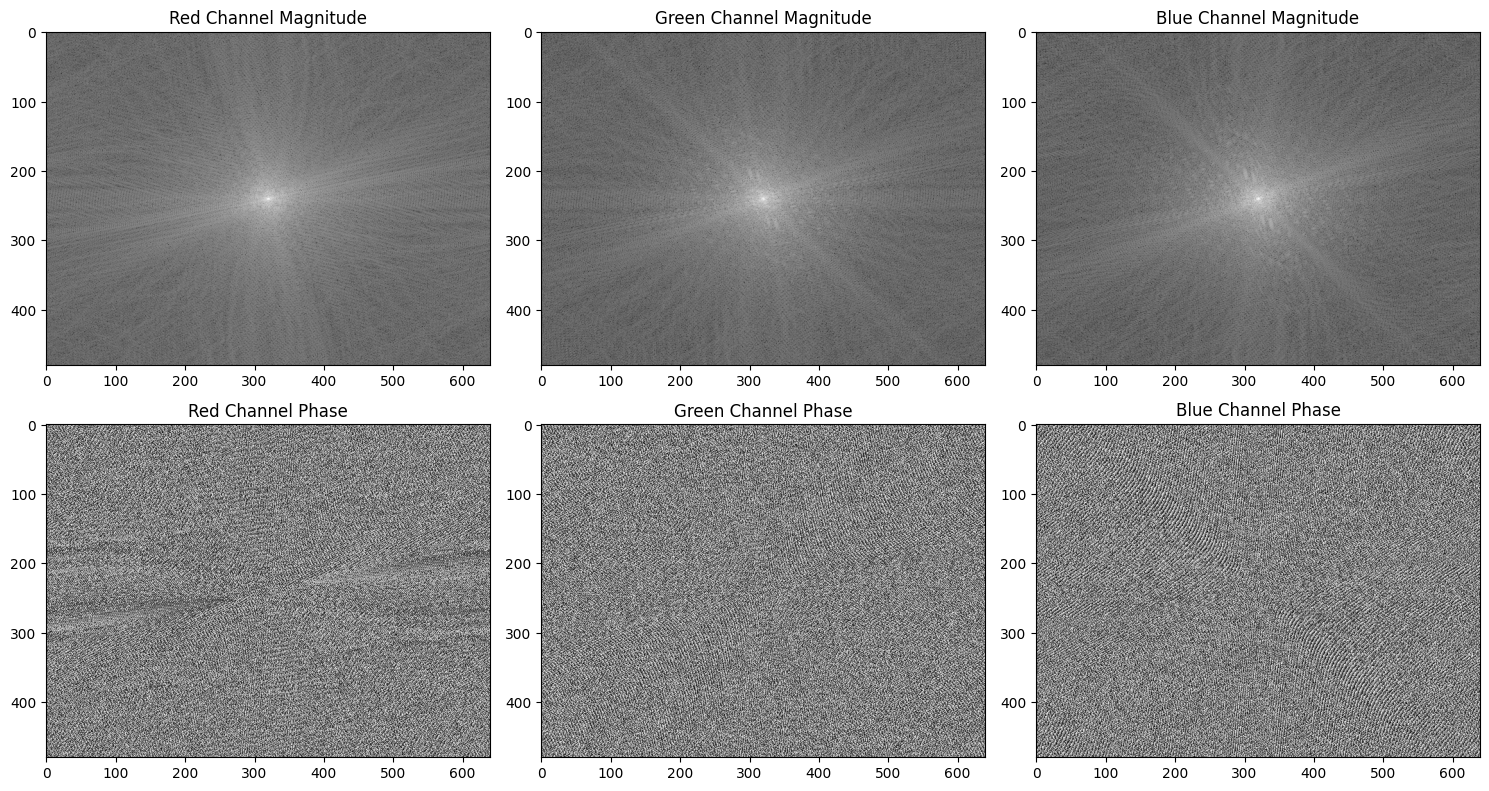

png_test_red.png


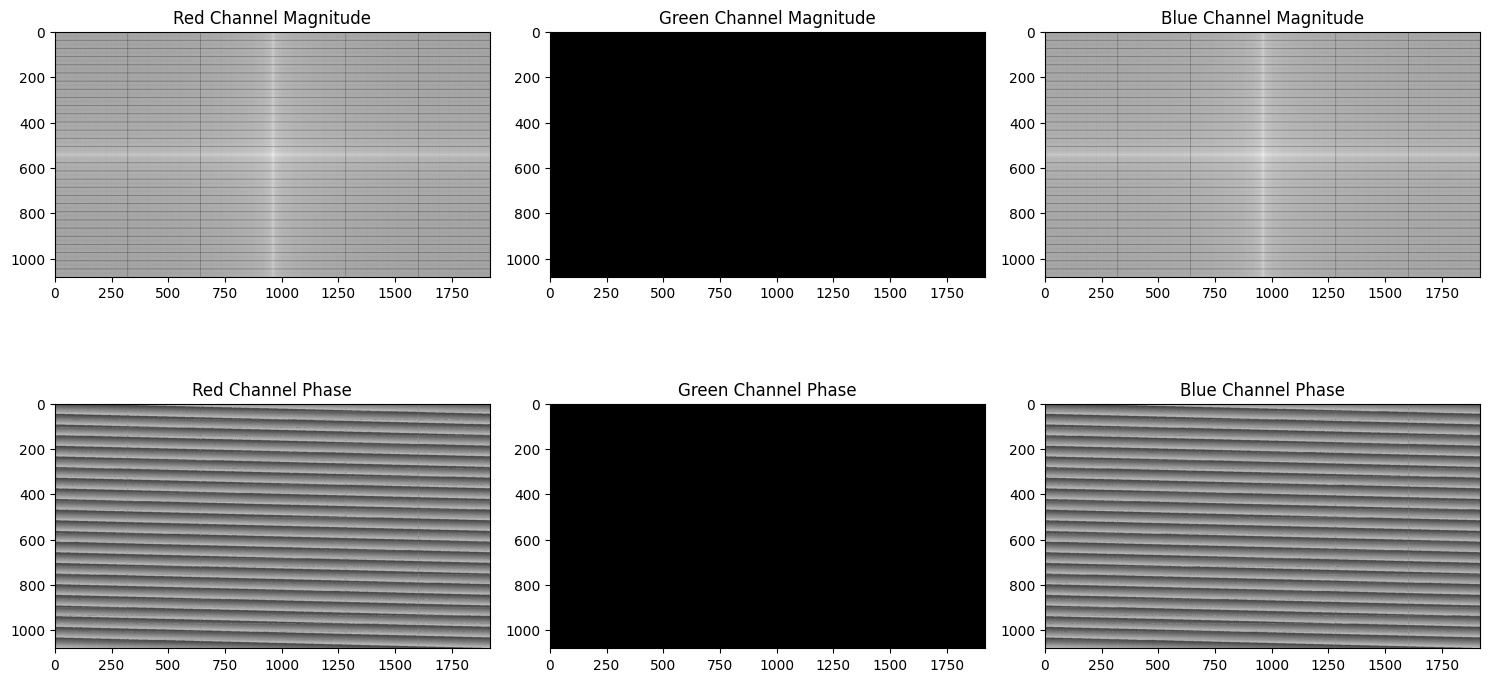

png_test_blue.png


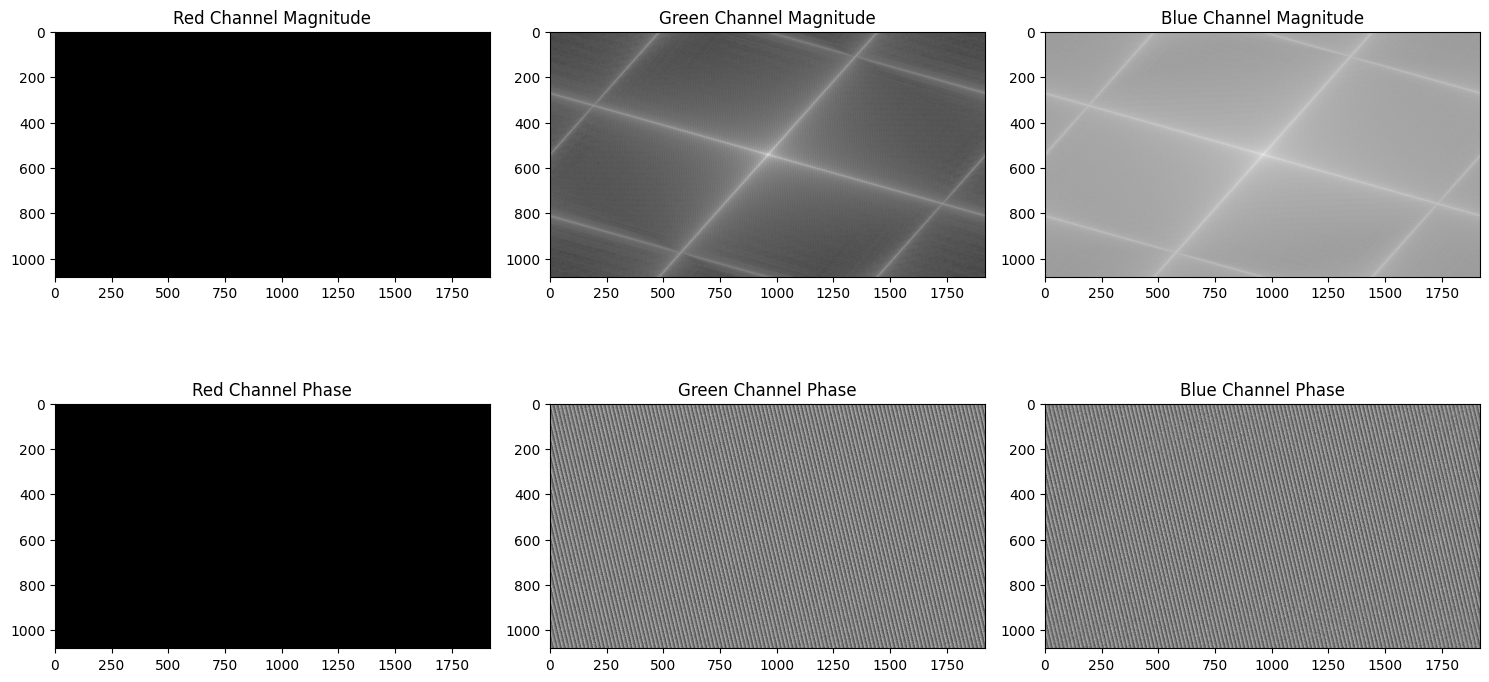

png_test_green.png


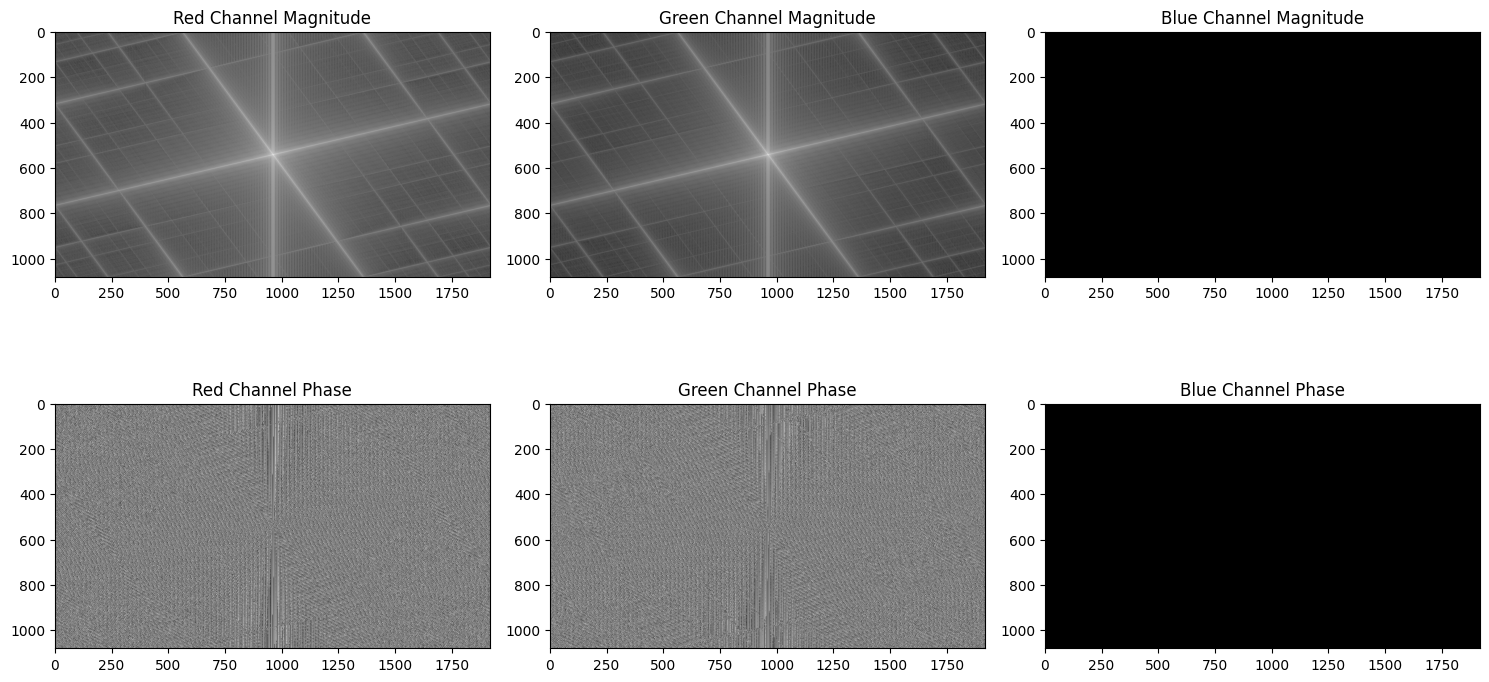

In [ ]:
def showSpectrum(path, palette=None): # Widmo czestotliwosciowe obrazu
    """Display frequency spectrum for PNG images based on color type"""
    orig_img = Image.open(path)

    file = open(path, "rb")
    chunks = read_chunks(file)
    file.close
    IHDR = decode_IHDR(chunks[0])
    color_type = IHDR["color_type"]
    
    plt.figure(figsize=(15, 8))
    
    # obraz czarno-bialy
    if color_type == 0:
        grayscale_img = orig_img.convert('L')
        mag_spectrum, phase_spectrum = getMagnitudeSpectrum(np.array(grayscale_img))
        
        plt.subplot(1, 2, 1)
        plt.imshow(mag_spectrum, cmap='gray') # widmo amplitudy w skali szarosci 
        plt.title("Magnitude Spectrum")
        
        plt.subplot(1, 2, 2)
        plt.imshow(phase_spectrum, cmap='gray') # widmo fazy w skali szarosci
        plt.title("Phase Spectrum")
    
    # Kolory RGB
    elif color_type == 2:
        img_array = np.array(orig_img)
        
        for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], np.rollaxis(img_array, -1))):
            mag, phase = getMagnitudeSpectrum(channel)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(mag, cmap='gray')
            plt.title(f"{color} Channel Magnitude")
            
            plt.subplot(2, 3, i+4)
            plt.imshow(phase, cmap='gray')
            plt.title(f"{color} Channel Phase")
    
    # Indexed color - kolory z palety
    elif color_type == 3 and palette is not None:
        img_array = np.array(orig_img)
        palette_rgb = np.array(palette, dtype=np.uint8).reshape(-1, 3)
        rgb_array = palette_rgb[img_array] # zamienia każdy indeks na odpowiadający mu kolor RGB
        
        for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], np.rollaxis(rgb_array, -1))):
            mag, phase = getMagnitudeSpectrum(channel)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(mag, cmap='gray')
            plt.title(f"{color} Channel Magnitude")
            
            plt.subplot(2, 3, i+4)
            plt.imshow(phase, cmap='gray')
            plt.title(f"{color} Channel Phase")
    
    # Grayscale with alpha
    elif color_type == 4:
        img_array = np.array(orig_img)
        grayscale = img_array[:, :, 0]  # Bierzemy tylko grayscale
        
        mag, phase = getMagnitudeSpectrum(grayscale)
        
        plt.subplot(1, 2, 1)
        plt.imshow(mag, cmap='gray')
        plt.title("Grayscale Magnitude Spectrum")
        
        plt.subplot(1, 2, 2)
        plt.imshow(phase, cmap='gray')
        plt.title("Grayscale Phase Spectrum")
    
    # Truecolor with alpha
    elif color_type == 6:
        img_array = np.array(orig_img)
        
        for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], np.rollaxis(img_array[:, :, :3], -1))):
            mag, phase = getMagnitudeSpectrum(channel)
            
            plt.subplot(2, 3, i+1)
            plt.imshow(mag, cmap='gray')
            plt.title(f"{color} Channel Magnitude")
            
            plt.subplot(2, 3, i+4)
            plt.imshow(phase, cmap='gray')
            plt.title(f"{color} Channel Phase")
    
    plt.tight_layout()
    plt.show()

def getMagnitudeSpectrum(image_data):
    """Calculate magnitude and phase spectrum of an image"""
    f = np.fft.fft2(image_data) # transformata fouriera obrazu 
    fshift = np.fft.fftshift(f) # przesunięcie środka spectrum do srodka obrazu
    magnitude = 20 * np.log(np.abs(fshift) + 1e-10) # magnituda
    phase = np.angle(fshift) # faza
    return magnitude, phase

print("png.png")
showSpectrum("png.png")
print("png_test_red.png")
showSpectrum("png_test_red.png")
print("png_test_blue.png")
showSpectrum("png_test_blue.png")
print("png_test_green.png")
showSpectrum("png_test_green.png")

## Źródła

- http://www.libpng.org/pub/png/spec/1.2/PNG-Structure.html